## Import Libraries & Data

### Libraries
Lets import the R packages we will be using

In [ ]:
#-----    Install Libraries ----#
#Install leaflet
if (!require(leaflet)) install.packages('leaflet')

#dplyr=
if (!require(dplyr)) install.packages('dplyr')

#Rcolorbrewer
if (!require(RColorBrewer)) install.packages('RColorBrewer')

#ggplot2
if (!require(ggplot2)) install.packages('ggplot2')

#ggpubr
if (!require(ggpubr)) install.packages('ggpubr')

#tidyr
if (!require(tidyr)) install.packages('tidyr')

#lubridate
if (!require(lubridate)) install.packages('lubridate')

Loading required package: leaflet

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘leaflet’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘lazyeval’, ‘terra’, ‘crosstalk’, ‘leaflet.providers’, ‘png’, ‘raster’, ‘sp’




### Data set
<br>
The data set is available from the Hubway Challenge website at the link below:


[Hubway Challange Dataset](http://files.hubwaydatachallenge.org/hubway_2011_07_through_2013_11.zip)
<br>
<br>

The hubway trip history data includes:

* Trip duration (in seconds)
* Start time and date
* Stop time and date
* Start station Name and ID
* End station Name and ID
* Bike ID
* User type
  * casual = single trip or day pass user
  * member = annual or monthly membership (unlimited use)
* Birth Year
* Gender (self reported by members, not required for casual)
<br>
<br>

In [ ]:
#-----     Importing Datasets            -----#
      # Set url link for the location of the dataset
      HubwayURL <- "http://files.hubwaydatachallenge.org/hubway_2011_07_through_2013_11.zip"

      # Download the .zip file and unzip contents
      download.file(HubwayURL, dest = "hubway.zip", mode = "wb")
      unzip("hubway.zip", exdir = "hubway")

      # Assess the files contained in the .zip file and then import each dataset
      list.files("hubway")
      hubway_stations <- read.csv(unz("hubway.zip", "hubway_stations.csv"))
      hubway_trips <- read.csv(unz("hubway.zip", "hubway_trips.csv"))

      #Basic Descriptive Info
      hubway_trips[1:5, 1:10]
      str(hubway_trips)
      dim(hubway_trips)

## Creating Interactive Map of Boston Area

### Create Boston MBTA Subway Stations Map
An interactive map of Boston's MBTA Subway Stations was created using
[Ray Cha's Open Transit Data Toolkit](https://transitdatatoolkit.com/lessons/mapping-a-transit-system/)
<br>


In [ ]:
#-----     Importing Datasets            -----#
      # Set url link for the location of the dataset
      StopsURL <- "https://cdn.mbta.com/MBTA_GTFS.zip"

      # Download the .zip file and unzip contents
      download.file(StopsURL, dest = "MBTA_GTFS.zip", mode = "wb")
      unzip("MBTA_GTFS.zip", exdir = "MBTA")

      # Assess the files contained in the .zip file and then import each dataset
      list.files("MBTA")
      #hubway_stations <- read.csv(unz("MBTA_GTFS.zip", "hubway_stations.csv"))
      #hubway_trips <- read.csv(unz("MBTA_GTFS.zip", "hubway_trips.csv"))

      #Basic Descriptive Info
      #hubway_trips[1:5, 1:10]
      #str(hubway_trips)
      #dim(hubway_trips)

[1] "agency.txt"                           
 [2] "calendar_attributes.txt"              
 [3] "calendar_dates.txt"                   
 [4] "calendar.txt"                         
 [5] "checkpoints.txt"                      
 [6] "directions.txt"                       
 [7] "facilities_properties_definitions.txt"
 [8] "facilities_properties.txt"            
 [9] "facilities.txt"                       
[10] "feed_info.txt"                        
[11] "levels.txt"                           
[12] "lines.txt"                            
[13] "linked_datasets.txt"                  
[14] "multi_route_trips.txt"                
[15] "pathways.txt"                         
[16] "route_patterns.txt"                   
[17] "routes.txt"                           
[18] "shapes.txt"                           
[19] "stop_times.txt"                       
[20] "stops.txt"                            
[21] "transfers.txt"                        
[22] "trips.txt"

In [ ]:
#####-----     Mapping Stations     -----#####
    #--- Create the Boston Subway Stations Map ---#
          # MBTA mapping code provided by - Ray Cha's Open Transit Data Toolkit:
          # https://transitdatatoolkit.com/lessons/mapping-a-transit-system/

          # Read in MBTA Station txt file
          # File named "stops" included in zip file and should be loaded into your working directory
          #Download stops file into your working directory first
          rawlocs <- read.csv(file="MBTA/stops.txt", head=TRUE,sep=",")

          # Select columns with MBTA T stations
          station_locs <- rawlocs

          #Select the columns we want and change columns name to latitude and longitude
          station_locs <- station_locs[c("stop_id","stop_desc","stop_name","platform_code","stop_lat","stop_lon","parent_station")]
          colnames(station_locs)[1] <- "id"
          colnames(station_locs)[2] <- "terminal"
          colnames(station_locs)[3] <- "station_name"
          colnames(station_locs)[4] <- "municipal"
          colnames(station_locs)[5] <- "latitude"
          colnames(station_locs)[6] <- "longitude"
          colnames(station_locs)[7] <- "status"

          # Convert the columns imported as a factor to characters
          station_locs$id <- as.character(station_locs$id)
          station_locs$station_name <- as.character(station_locs$station_name)

          # Remove all the rows which do not contain numbers
          station_locs <- station_locs[!is.na(as.numeric(station_locs$id)), ]

          # Convert the Stop ID column into numbers
          station_locs$id = as.numeric(station_locs$id)

          # Select columns with MBTA T stations
          station_locs <- station_locs[which ((station_locs$id >= 70000) & (station_locs$id <= 70279) ),]


          # Saint Paul Street Station names are altered to include their line.
          # This change is doen to be able to distinguish the two stations
          # named Saint Paul Street on the B and C line.

          station_locs$station_name[station_locs$id == 70141] <-  "Saint Paul Street B Line"
          station_locs$station_name[station_locs$id == 70218] <-  "Saint Paul Street C Line"

          # Find the unique lat and lon coordinates
          station_locs <- station_locs[!duplicated(station_locs[c("latitude", "longitude")]),]

          # Select the rows which do not have Outbound in the text
          # Remove string with dash
          station_locs$station_name <- sub("\\-.*","",station_locs$station_name)

          #Remove and extra spaces
          station_locs$station_name <- trimws(station_locs$station_name,which = c("right"))

          station_locs$type <- c("MBTA-Subway")

          # Map the stations
          # Lat Long corrdinates from www.latlong.net
          mbta_subway <- leaflet(station_locs) %>%
            addTiles() %>%
            setView(-71.057083, 42.361145, zoom = 12) %>%
            addCircles(~longitude, ~latitude, weight = 3, radius=120,
                       color="#0b2f4c", stroke = TRUE, fillOpacity = 0.8) %>%
            addLegend("bottomleft", colors="#0b2f4c", labels="Data Source: MBTA Developer Portal", title="MBTA Subway Stations")

          # show the map
          mbta_subway

Warning message in `[.data.frame`(station_locs, !is.na(as.numeric(station_locs$id)), :
“NAs introduced by coercion”


HTML widgets cannot be represented in plain text (need html)

![MBTA SUbway Stations](https://github.com/frnunez/frnunez.github.io/raw/master/images/visualization/mbtastationsmap.jpeg)

### BLUE Bikes Station Location Map
A similar map was created using the hubway stations data

In [ ]:
#-----     Creating BLUE bikes Station Location Map           -----#
          # Blue Bikes branding
          # https://motivateco.app.box.com/s/cw4tluatehnpfff4wzmch7v2f4ewa0uz

          #--- Modifying Data ---#
          stations <- hubway_stations

          # Change column names
          colnames(stations)[3] <- "station_name"
          colnames(stations)[5] <- "latitude"
          colnames(stations)[6] <- "longitude"

          # Convert the columns imported as a factor to characters
          stations$station_name <- as.character(stations$station_name)

          # Convert the ID column into numbers
          stations$id = as.numeric(stations$id)

          stations$type <- c("BLUEbikes")

          #--- Create the BLUEbikes Stations Map ---#
          # Lat Long corrdinates from www.latlong.net
          station_map <- leaflet(stations) %>%
            addTiles() %>%
            setView(-71.057083, 42.361145, zoom = 12) %>%
            addCircles(~longitude, ~latitude, weight = 3, radius=120,
                       color="#0090DA", stroke = TRUE, fillOpacity = 0.8) %>%
            addLegend("bottomleft", colors="#0090DA", labels="Data Source: Hubway Challenge Dataset", title="Hubway BLUEbikes Station Locations")

          # Plot the map
          station_map

HTML widgets cannot be represented in plain text (need html)

![alt text](https://github.com/frnunez/frnunez.github.io/raw/master/images/visualization/bluebikesstationsmap.jpeg)

### Combined Map
Station locations were consolidated into one interactive map. The first thing we noticed is that the northwestern quadrant of the map has very few MBTA Stations. This is clearly an underserved area and we expected to see some high usage of Blue Bikes in this area. The addition of the bike stations added an additional mode of transportation to the downtown Boston area.

In [ ]:
   #--- Combine Both Maps into one ---#
          #https://rstudio.github.io/leaflet/markers.html

          bostonstations <- rbind(stations,station_locs)

          #Plot map
          #colors
          pal <- colorFactor(c("#0090DA", "#0b2f4c"), domain = c("BLUEbikes", "MBTA-Subway"))

          #plot map
          boston_map <- leaflet(bostonstations) %>%
            addTiles() %>%
            setView(-71.057083, 42.361145, zoom = 12) %>%
            addCircles(~longitude, ~latitude, weight = 3, radius=~ifelse(type == "type", 120, 120),
                       color=~pal(type), stroke = TRUE, fillOpacity = 0.8) %>%
            addLegend("bottomleft", pal=pal, values=~type, title="MBTA Subway & Bluebike Stations")
          boston_map

HTML widgets cannot be represented in plain text (need html)

![alt text](https://github.com/frnunez/frnunez.github.io/raw/master/images/visualization/bostonstationsmap.jpeg)

## Trips Data Preparation

In [ ]:
#####-----     Trips Data     -----#####
 #--- Main Trips Data ---##
    # Total Trips set
        trips <- hubway_trips

        # Clean Up
              trips$gender <- as.character(trips$gender)
              trips$gender[trips$gender==""] <- "Unreported"
              trips$gender <- as.factor(trips$gender)
              trips$zip_code <- as.character(trips$zip_code)
              trips$zip_code[trips$zip_code==""] <- "Unreported"
              trips$zip_code <- as.factor(trips$zip_code)

        # Create Age Column (Approximate)
              trips <- trips %>%
                mutate(age = 2019-birth_date)

        # Basic Stats
              summary(trips)

    # Create Casual ONLY Set
          tripscasual <- filter(trips, subsc_type=="Casual")
          tripscasual <- tripscasual[,c(1,2,4:9)] #Removed Unreported Columns (Zip, DOB, Gender)

    # Create Regsitered ONLY Set
          tripsregistered <- filter(trips, subsc_type=="Registered")

     seq_id          hubway_id          status           duration       
 Min.   :      1   Min.   :      8   Closed:1579025   Min.   :   -6900  
 1st Qu.: 394757   1st Qu.: 446525                    1st Qu.:     412  
 Median : 789513   Median : 895044                    Median :     660  
 Mean   : 789513   Mean   : 886532                    Mean   :    1200  
 3rd Qu.:1184269   3rd Qu.:1328083                    3rd Qu.:    1082  
 Max.   :1579025   Max.   :1748022                    Max.   :11994458  
                                                                        
               start_date        strt_statn                    end_date      
 7/30/2013 17:18:00 :     25   Min.   :  3.00   10/19/2013 16:26:00:     27  
 8/6/2013 17:50:00  :     25   1st Qu.: 27.00   9/10/2013 17:43:00 :     26  
 9/10/2013 17:04:00 :     25   Median : 48.00   8/13/2013 18:08:00 :     24  
 10/4/2013 17:06:00 :     24   Mean   : 54.38   8/5/2013 17:30:00  :     24  
 7/30/2013 17:30:00 :     

## Data Exploration
Our first exploration was to look at the registered users vs casual riders (non-registered). We see that 70% of the total riders were registerd users.

subsc_type,counts
<fct>,<int>
Casual,472611
Registered,1106414


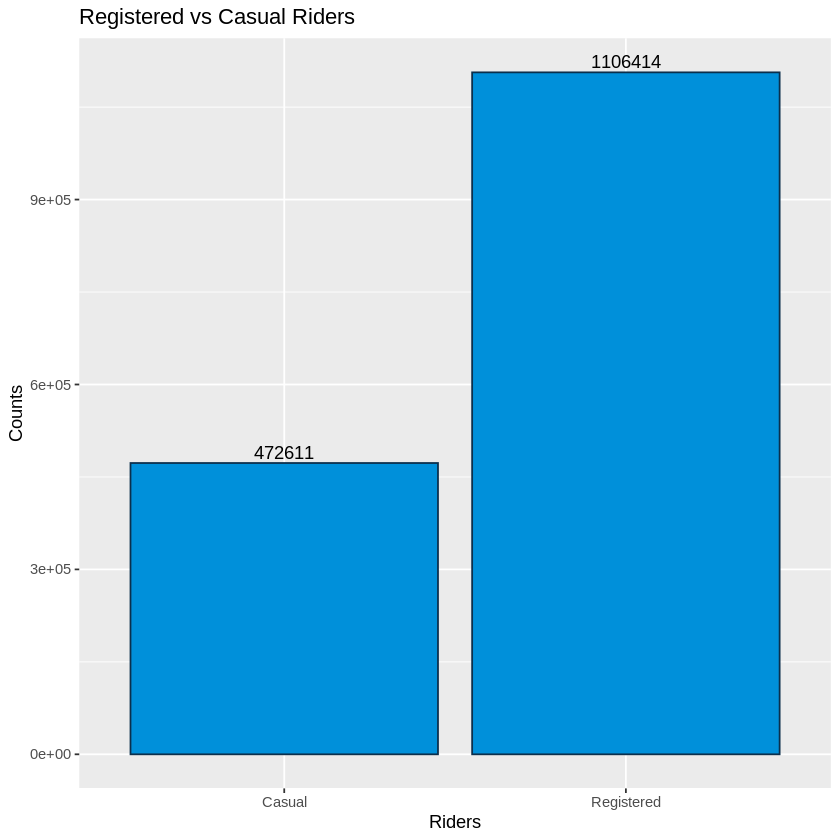

In [ ]:
 #--- Basic User/Rider Demographics ---#
    # Casual vs Registered
         ridership <- trips %>%
           group_by(subsc_type) %>%
           summarise(counts = n())
         ridership

         #Bar Chart
         ggplot(ridership, aes(x=subsc_type, y=counts, fill=subsc_type)) +
           geom_bar(stat = "identity", color="#0b2f4c", fill = "#0090DA") +
           geom_text(aes(label = counts), vjust = -0.3) +
           ggtitle("Registered vs Casual Riders") + xlab("Riders") + ylab("Counts")

Warning message in brewer.pal(2, "Blues"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


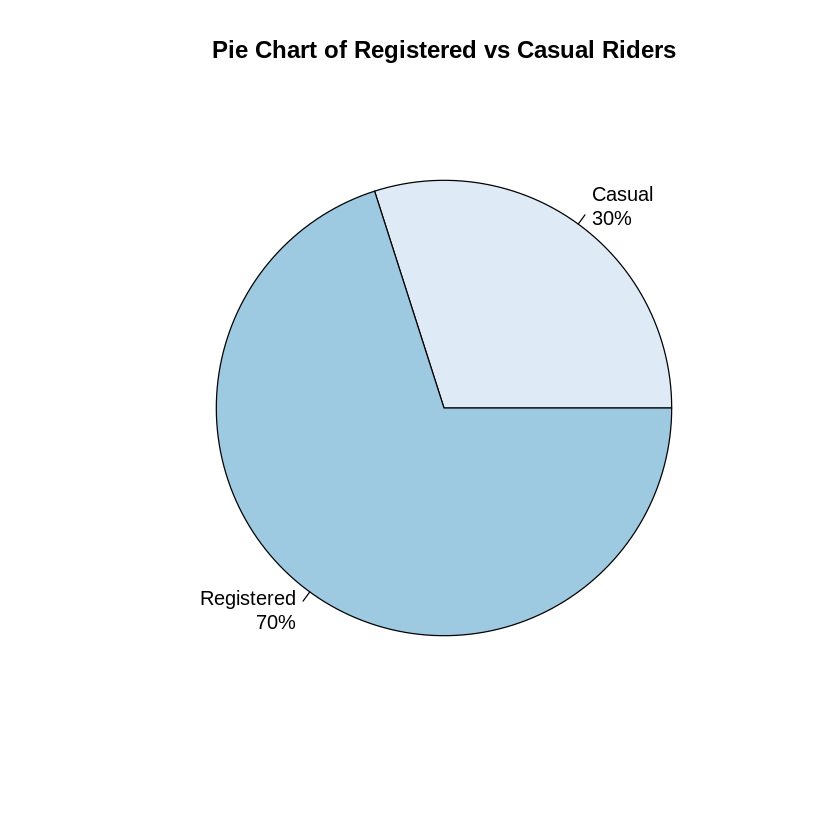

In [ ]:
         # Pie Chart version
         regtable <- table(trips$subsc_type)
         regtable <- sort(regtable)
         pct <- round(regtable/sum(regtable)*100)
         lbls <- paste(names(regtable), "\n", pct, sep="")
         lbls <- paste(lbls,"%",sep="") # ad % to labels
         pie(regtable, labels = lbls, col=brewer.pal(2, "Blues"),
             main="Pie Chart of Registered vs Casual Riders")

Next we explored the distribution of usage by reported gender. When we looked at all records, we saw that 53% of riders reported being males, 17% female and  30% unreported. We suspected that this was not a fair assessment of gender and it heavily skewed towards unreported due to the fact that gender did NOT need to be reported by casual riders.

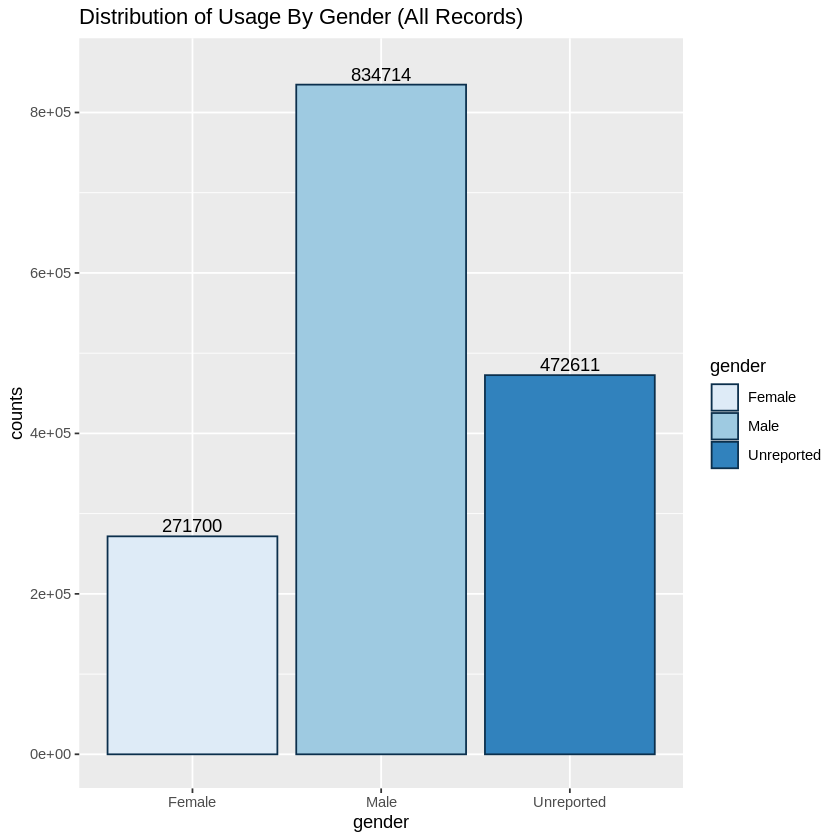

In [ ]:
    # Rides By Gender
        # All Records
              gentrips <- trips %>%
                group_by(gender) %>%
                summarise(counts = n())

              ggplot(gentrips, aes(x = gender, y = counts, fill=gender)) +
                geom_bar(stat = "identity", color="#0b2f4c") + scale_fill_brewer(palette="Blues") +
                geom_text(aes(label = counts), vjust = -0.3) +
                ylim(0,850000)+ ggtitle("Distribution of Usage By Gender (All Records)")

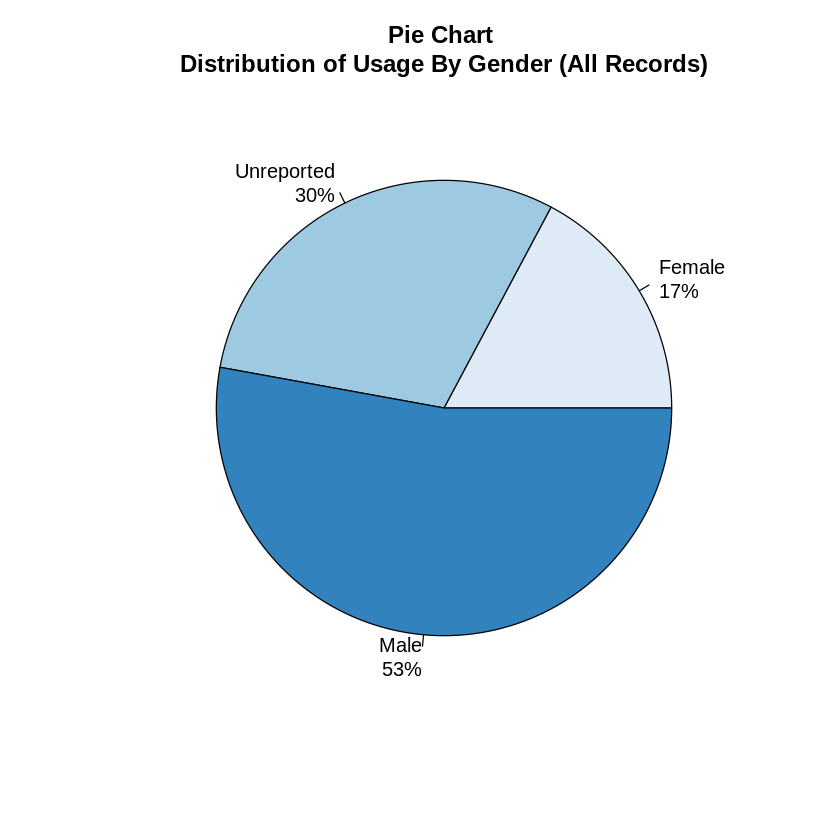

In [ ]:
              # Pie Chart version
              gendertable <- table(trips$gender)
              gendertable <- sort(gendertable)
              pct <- round(gendertable/sum(gendertable)*100)
              lbls <- paste(names(gendertable), "\n", pct, sep="")
              lbls <- paste(lbls,"%",sep="") # ad % to labels
              pie(gendertable, labels = lbls, col=brewer.pal(3, "Blues"),
                  main="Pie Chart \nDistribution of Usage By Gender (All Records)")

When we looked at just the registered riders, we saw that 75% of the registered riders reported being male, while 25% reported being female. Focusing on just the registred user would eliminate 30% of our data but it would allow us to get a better picture of the riders.

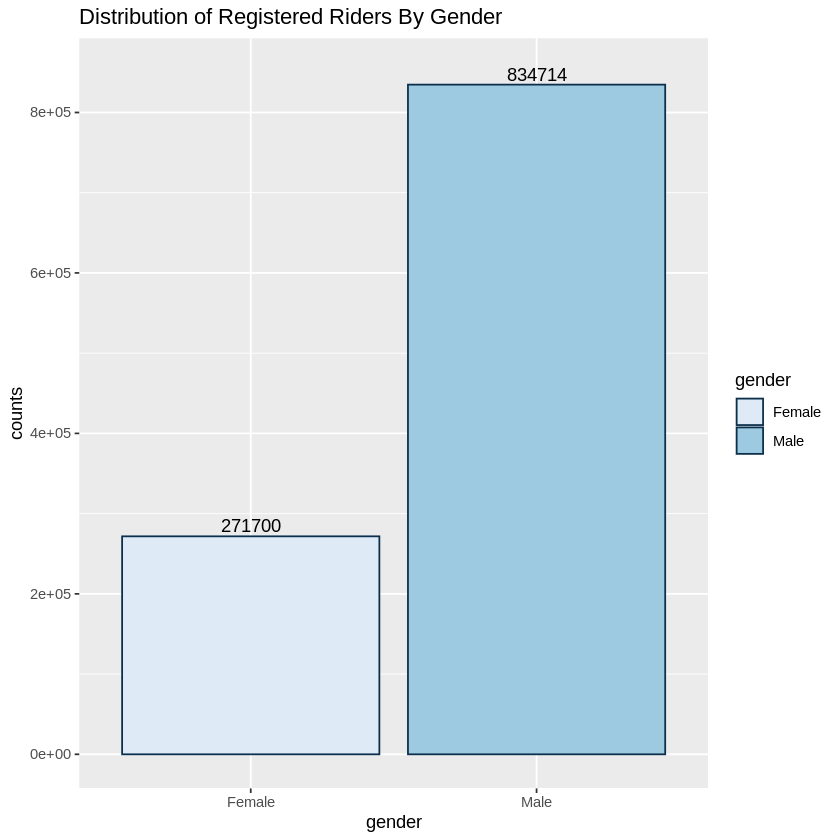

In [ ]:
        # Registered Users ONLY
              genreg <- tripsregistered %>%
                group_by(gender) %>%
                summarise(counts = n())

              ggplot(genreg, aes(x = gender, y = counts, fill=gender)) +
                geom_bar(stat = "identity", color="#0b2f4c") + scale_fill_brewer(palette="Blues") +
                geom_text(aes(label = counts), vjust = -0.3) +
                ylim(0,850000)+ ggtitle("Distribution of Registered Riders By Gender")

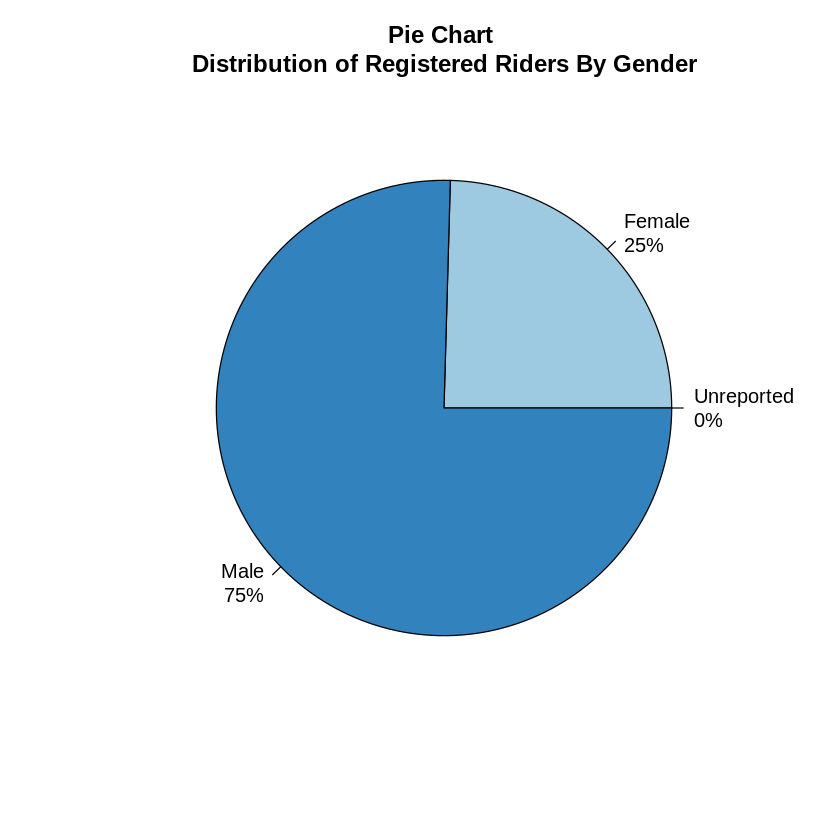

In [ ]:
              # Pie Chart version
              genregtable <- table(tripsregistered$gender)
              genregtable <- sort(genregtable)
              pct <- round(genregtable/sum(genregtable)*100)
              lbls <- paste(names(genregtable), "\n", pct, sep="")
              lbls <- paste(lbls,"%",sep="") # ad % to labels
              pie(genregtable, labels = lbls, col=brewer.pal(3, "Blues"),
                  main="Pie Chart \nDistribution of Registered Riders By Gender")

Next we looked at the age distribution. Age was also not a required field for casual riders and thus this information only includes the registered users. A quick look at some statistical information shows us that only 31.69% of registred riders (350,644 out of 1,106,414) reported their age.
<br>
<br>
Of those that did report their age, the mean age was 42.7 while the median age was 40. 95% of the ridership was between the ages of 34 and 50. The total age range was 24 - 87.

In [ ]:
    # Distribution of Age (No Casual Riders Reported Age)

              # Stats for All Rider Ages
              length(tripsregistered$age) # 1106414 total registered riders
              sum(is.na(tripsregistered$age)) # 755770 did not report their age
              sum(!is.na(tripsregistered$age)) # 350644 reported their age
              summary(tripsregistered$age) # 755770 did not report their age, 95% of riders are in the age range 34 - 50

[1] 1106414

[1] 755770

[1] 350644

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   24.0    34.0    40.0    42.7    50.0    87.0  755770 

In [ ]:
              # Calculate Mean of Age
              gendermean <- tripsregistered %>%
                group_by(gender) %>%
                summarise(mean=mean(age, na.rm=TRUE))
              gendermean

gender,mean
<fct>,<dbl>
Female,41.30244
Male,43.16753


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 755770 rows containing non-finite values (stat_bin).”


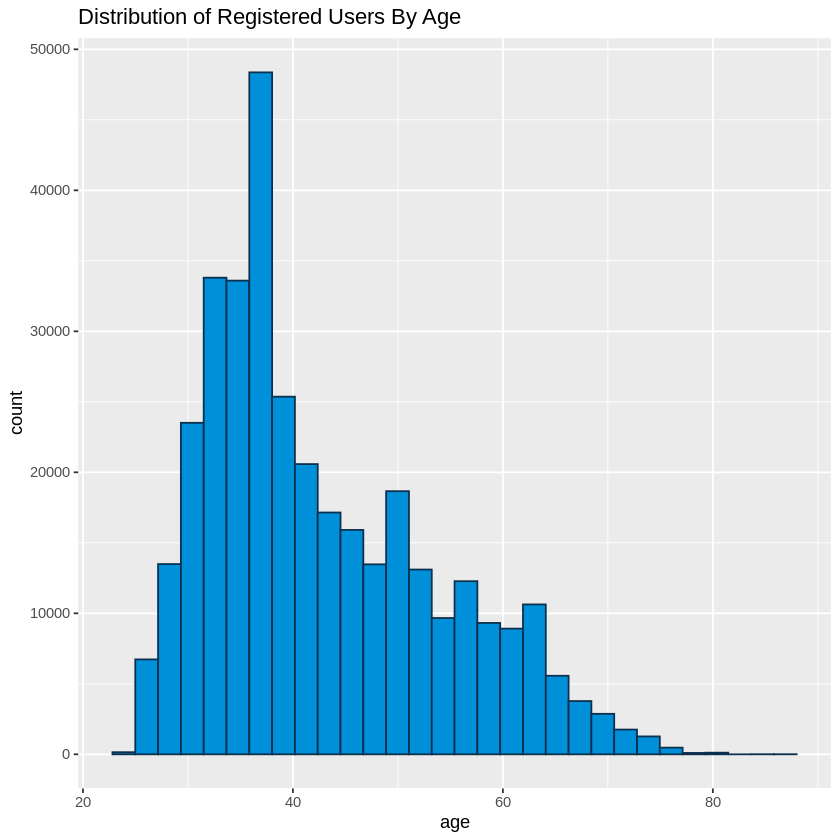

In [ ]:
              # Plot Histogram
              ggplot(tripsregistered, aes(age)) +
                geom_histogram(color="#0b2f4c", fill="#0090DA") +
                ggtitle("Distribution of Registered Users By Age")

We also wanted to look at the age distribution by gender.
<br>
<br>
For males, we had a mean of 43.2 and a median of 40. The age range for 95% of the riders in this group was 34 - 51 with an age range of 24 - 58.
<br>
<br>
For females, we saw a mean of 41.3 with a median of 38. The age range for 95% of the reiders in this group was 33 - 47 with an age range of 24 - 87.

In [ ]:
              # Distribution by Age and Gender
              males <- tripsregistered %>%
                filter(gender=="Male")

              females <- tripsregistered %>%
                filter(gender=="Female")

              # Summaries
              summary(males$age)
              summary(females$age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   24.0    34.0    40.0    43.2    51.0    85.0  571088 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   24.0    33.0    38.0    41.3    47.0    87.0  184682 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 755770 rows containing non-finite values (stat_bin).”


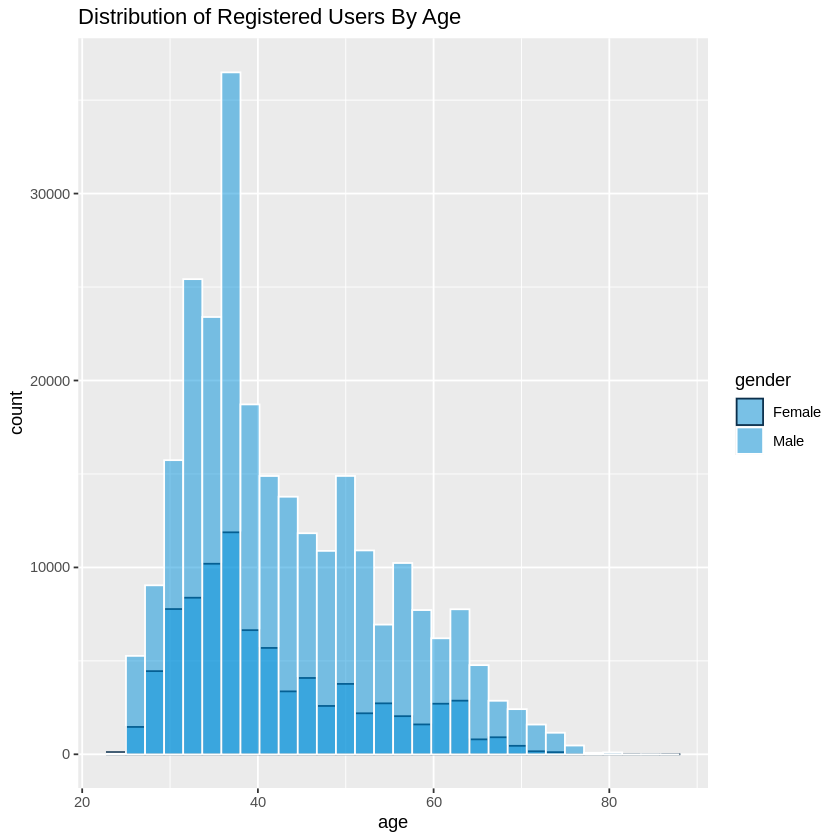

In [ ]:
              # Plots
              ggplot(tripsregistered, aes(x=age, color=gender))+
                geom_histogram(fill="#0090DA", alpha=0.5, position="identity") +
                scale_color_manual(values=c("#0b2f4c", "#FFFFFF")) +
                #scale_color_brewer(palette="Blues") +
                ggtitle("Distribution of Registered Users By Age")

When comparing the age distribution foor both genders, we see that the graphs were both right skewed. With a median age of 30 for females and 40 for males.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 755770 rows containing non-finite values (stat_bin).”


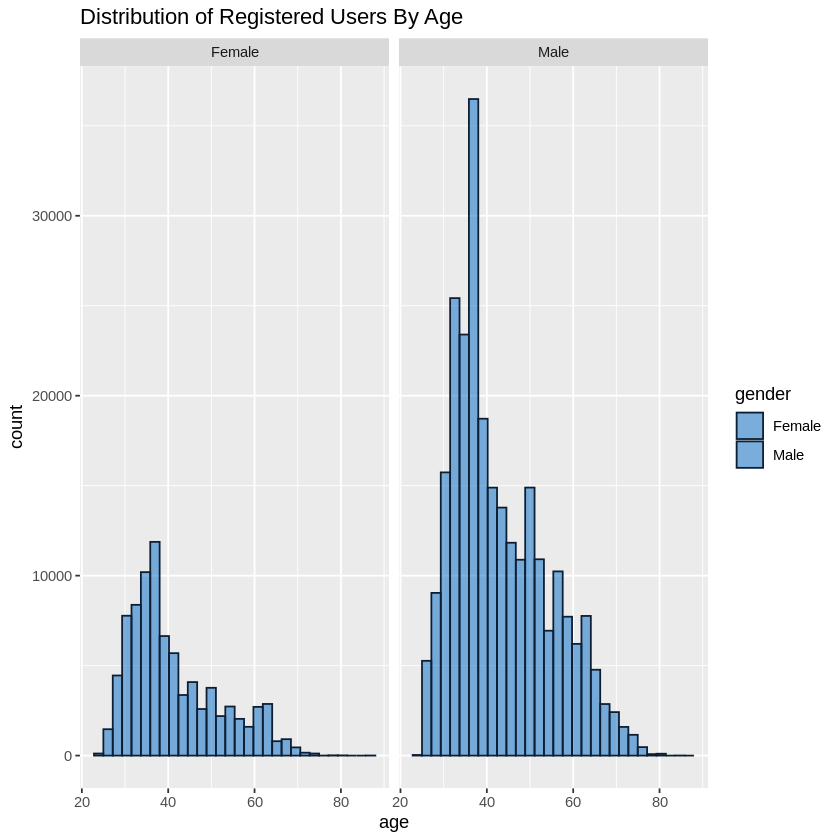

In [ ]:
              ggplot(tripsregistered, aes(x=age, color=gender))+
                geom_histogram(fill="#006AC6", alpha=0.5, position="identity") +
                scale_color_manual(values=c("#0D1D32", "#0D1D32")) +
                facet_wrap(~gender) +
                ggtitle("Distribution of Registered Users By Age")

Next, we looked at the duration of the trips to see how long riders were using the bikes for. Our initial observations included trips that lasted less than 60 seconds, and even some that somehow were listed as negative. We removed these trips from the set as there were numerous trips that were done for testing purposes and still included in the set. This also included trips were the bikes were originally started but due to reasons known by the rider, the bikes were redocked without actually going anywhere. In addition there were some trips which were noted as lasting over 24 hours. These were also removed from the set as there were other issues reported where a bike would not register as returned or may have been stolen.
<br>
<br>
Once the set was cleaned up, we converted the time from seconds to minutes. The median trip length was 11 minutes, with a mean of 17.472 minutes. The duration for 95% of this set was 7 - 18.250 minutes. The range was 1.017 - 1439.550 minutes.

In [ ]:
 #--- Trips Duration (Duration measured in seconds)---#
      # Creating Set and Clean Up
          tripsdur <- trips  %>%
            select(duration, subsc_type, birth_date, gender,age)
          summary(trips$duration)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   -6900      412      660     1200     1082 11994458 

In [ ]:
        # Clean Up of Outliers
          tripsdur <- tripsdur[tripsdur$duration > 60,] # Remove all trips less than 60 seconds.seconds in length (potentially false starts or users trying to re-dock a bike to ensure it was secure)
          tripsdur <- tripsdur[tripsdur$duration < 86400,] # Remove all trips greater than 86,400 seconds (24 hours)
          summary(tripsdur$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     61     420     660    1048    1095   86373 

In [ ]:
        # Convert Duration from Seconds to Minutes
          tripsdur <- tripsdur %>%
            mutate(duration=(duration/60))
          summary(tripsdur$duration)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   1.017    7.000   11.000   17.472   18.250 1439.550 

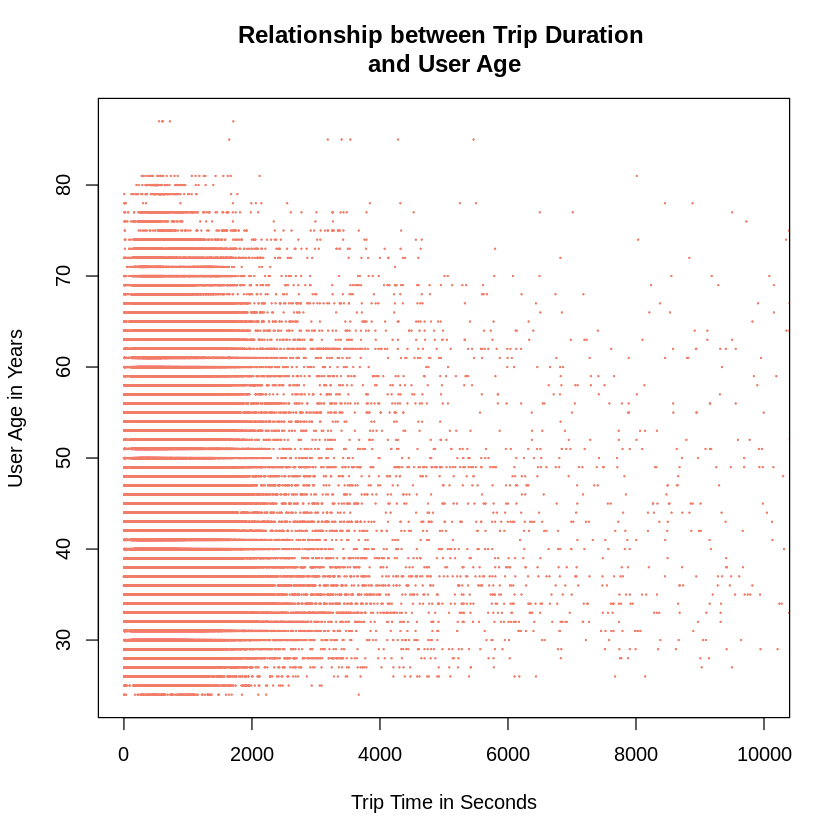

In [ ]:
   ## - Age vs Duration - ##
      # Plot of Relationship between duration and age
        plot(trips$duration, trips$age,xlim= c(1, 10000),
             col = "#f17c67",pch=10, cex=.1 , xlab="Trip Time in Seconds",ylab="User Age in Years",
             main="Relationship between Trip Duration \nand User Age")

Warning message:
“Removed 1220375 rows containing missing values (geom_point).”


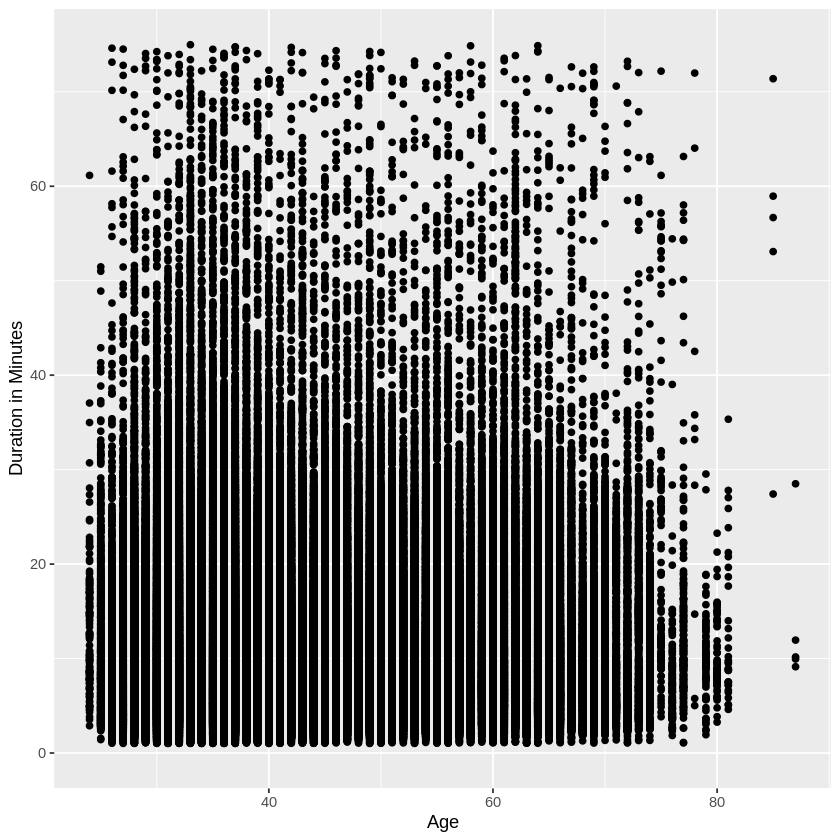

In [ ]:
      # Relationship between Age and Duration (Same as above, different view, removed outliers)
        ggplot(tripsdur, aes(age, (duration))) +
          geom_point() + xlab("Age") + ylab("Duration in Minutes") +
          ylim(0,75)

We looked for a relationship between the age and duration of trips. There wasnt much change in the duration by age with the exception of a few of the older users. The trip distances did not vary much.

Warning message:
“Removed 33744 rows containing non-finite values (stat_boxplot).”


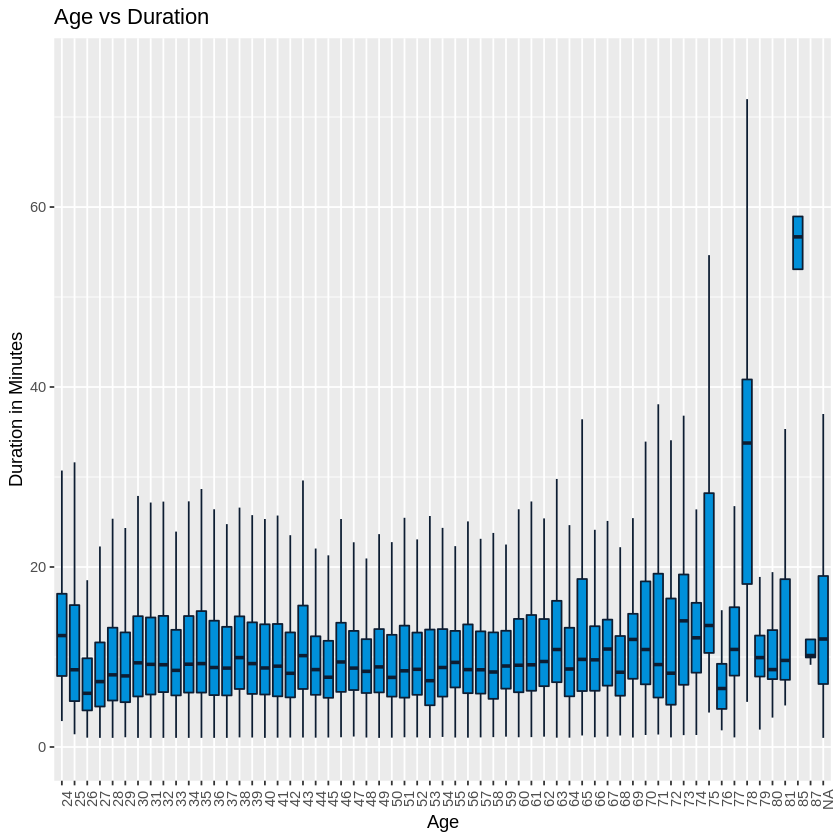

In [ ]:
      # Boxplot Age vs duration. Have to convert age to factor
        ggplot(tripsdur, aes(x=factor(age), y=(duration))) +
          geom_boxplot(outlier.shape=NA, fill="#0090DA", color="#0D1D32") + #remove outliers
          ggtitle("Age vs Duration") +
          theme(axis.text.x = element_text(angle = 90)) + xlab("Age") + ylab("Duration in Minutes") +
          ylim(0,75)

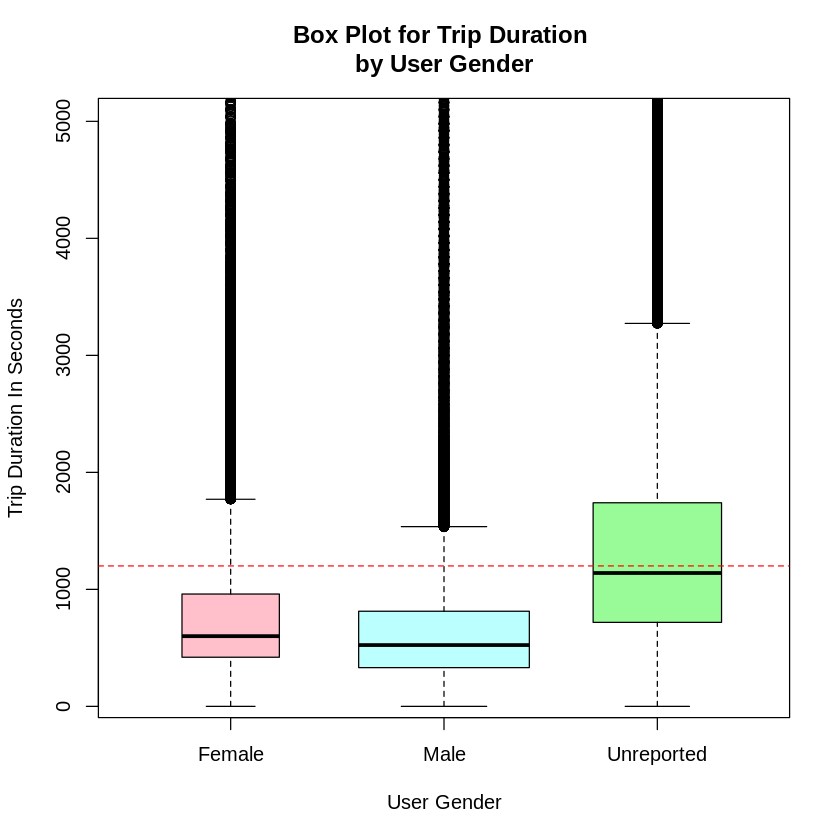

In [ ]:
   ## - Duration By Gender - ##
        # Bloxplot trip duration by user gender
          boxplot(trips$duration~trips$gender, axisnames = FALSE, ylim=c(100,5000), varwidth = TRUE, outline = TRUE,xlab="User Gender",
                  ylab="Trip Duration In Seconds",col=c("pink","paleturquoise1","palegreen"),main="Box Plot for Trip Duration \nby User Gender")
          abline(h=mean(trips$duration), lty=2,col="red")

Warning message:
“Removed 33744 rows containing non-finite values (stat_boxplot).”


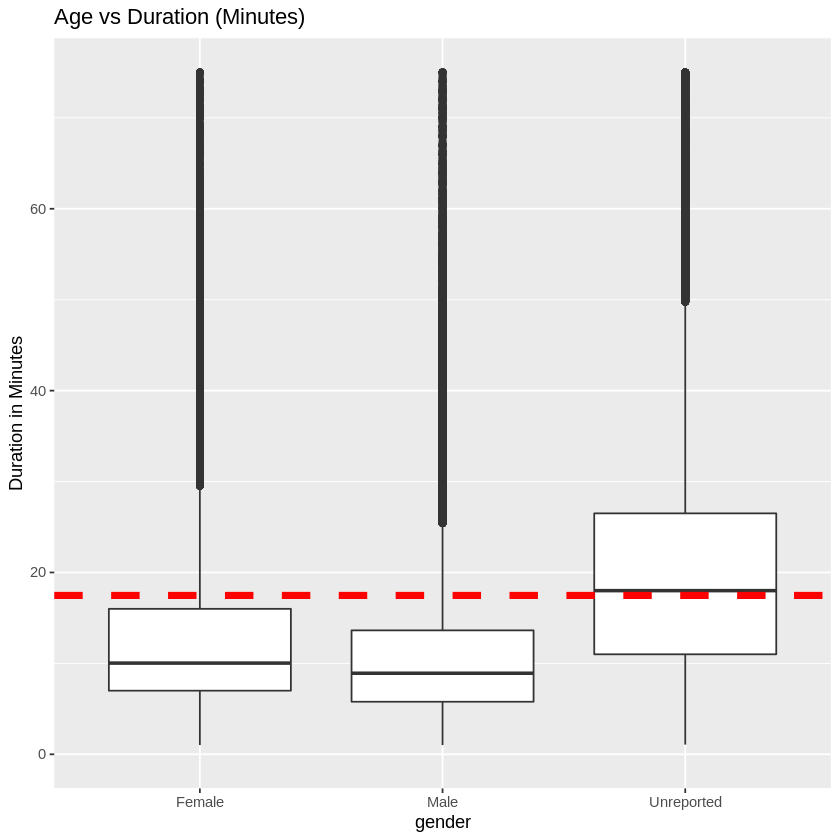

In [ ]:
        # Boxplot Duration by Gender (Versin 2)
        ggplot(tripsdur, aes(x=gender, y=duration)) +
          geom_boxplot() +
          ylim(0,75)+ ggtitle("Age vs Duration (Minutes)") + ylab("Duration in Minutes") +
          geom_hline(yintercept=(mean(tripsdur$duration)), linetype="dashed",color = "red", size=2)

We looked at the days of the week and saw that the majority of trips occured Monday to Friday. There was a drop off in trips during the weekend, particularly for Sunday.

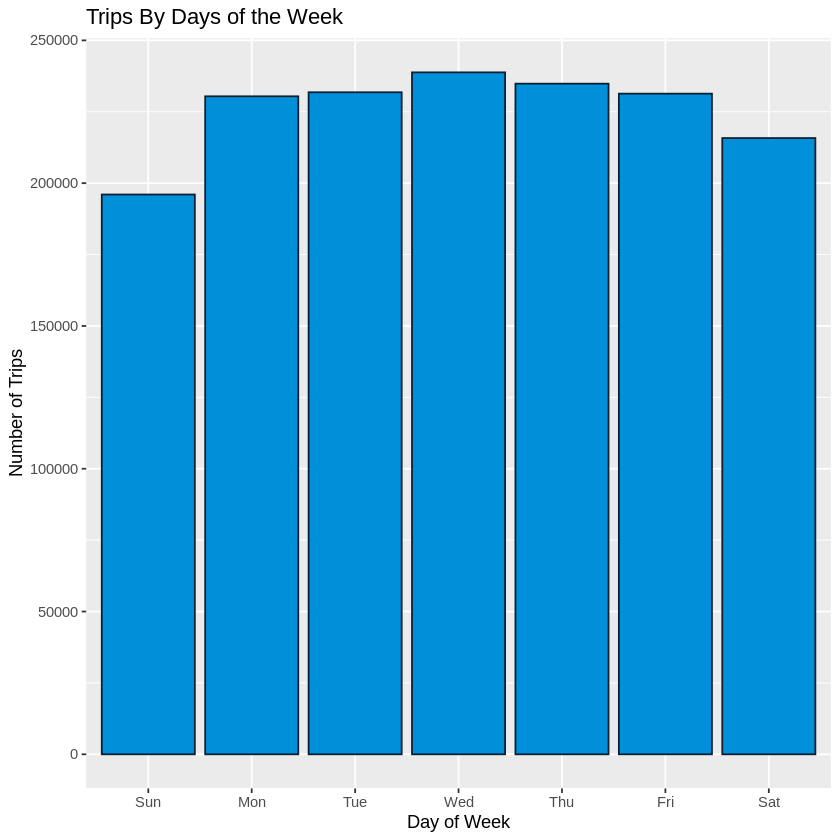

In [ ]:
#---------------------Trips over different days of the week and Trips by time of day-----------------------------------------#

#Creating Data Frames
        trips$start_date <- mdy_hms(hubway_trips$start_date, tz = 'EST')
        trips$end_date   <- mdy_hms(hubway_trips$end_date, tz = 'EST')

        trips$day_of_week <- wday(trips$start_date, label = TRUE)

#Plot
        ggplot(data = trips, aes(x = day_of_week)) + geom_bar(fill = '#0090DA', color="#0D1D32")+
          ggtitle("Trips By Days of the Week")+
          ylab("Number of Trips") +
          xlab("Day of Week")

We looked at trips by time of day, we noticed that there were two peaks, one around 8AM and the other at 5PM. When paired with the previous data showing that the majority of trips are occuring Monday to Friday we are predicting that these trips are mostly to and from work locations for the users.

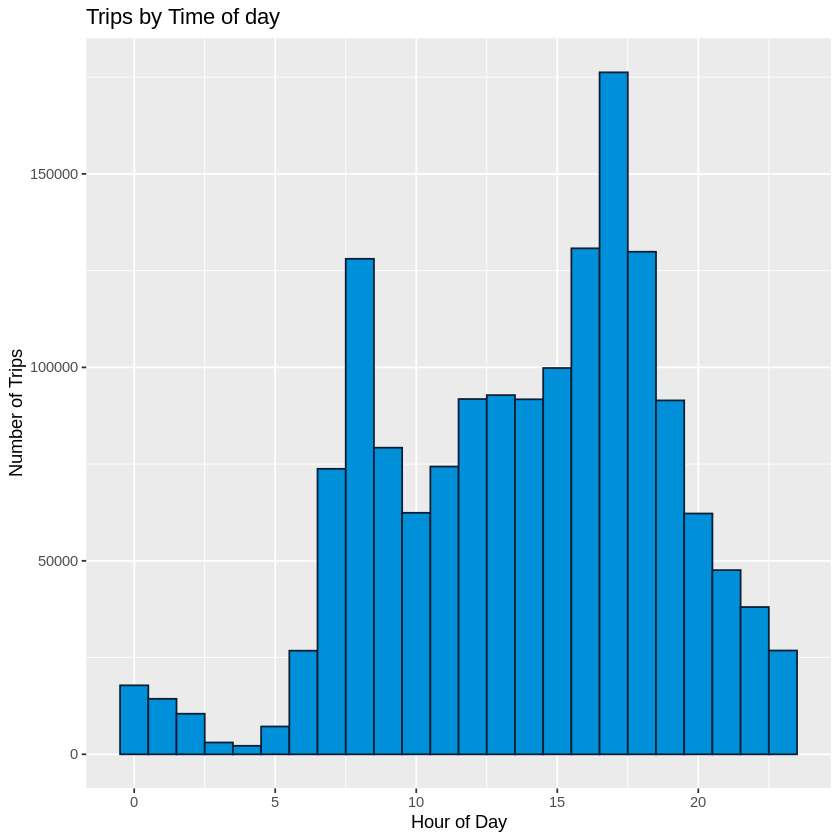

In [ ]:
    #Plot
        trips$hour_of_day <- hour(trips$start_date)
        ggplot(data = trips, aes(x = hour_of_day)) +
          geom_histogram(fill = '#0090DA', colour = '#0D1D32', binwidth = 1)+
          ggtitle("Trips by Time of day")+
          ylab("Number of Trips") +
          xlab("Hour of Day")

In [ ]:
 #--- Popular Destinations ---#
    # Popular Trips Set
      poptrips <- trips %>%
        select(start_date, strt_statn, end_date, end_statn, subsc_type, gender, age)
      poptrips$strt_statn <- as.factor(poptrips$strt_statn)
      poptrips$end_statn <- as.factor(poptrips$end_statn)
      poptrips <- poptrips[!is.na(poptrips$strt_statn), ] # remove NA start stations
      poptrips <- poptrips[!is.na(poptrips$end_statn), ] # remove NA end stations

    # Descriptive Data
      length(unique(poptrips$strt_statn)) #142 Unique Stations
      length(unique(poptrips$end_statn)) #142 Unique Stations
      summary(poptrips) #top 5 start and end listed in summary by number

[1] 142

[1] 142

   start_date                    strt_statn         end_date                  
 Min.   :2011-07-28 10:12:00   22     :  56442   Min.   :2011-07-28 10:12:00  
 1st Qu.:2012-08-07 09:29:00   36     :  42568   1st Qu.:2012-08-07 09:43:00  
 Median :2013-05-16 22:55:00   53     :  35438   Median :2013-05-16 23:11:00  
 Mean   :2013-02-03 08:11:57   67     :  33685   Mean   :2013-02-03 08:31:07  
 3rd Qu.:2013-08-22 20:42:00   16     :  32859   3rd Qu.:2013-08-22 21:01:00  
 Max.   :2013-11-30 23:39:00   42     :  32795   Max.   :2013-12-01 00:16:00  
                               (Other):1345186                                
   end_statn            subsc_type             gender            age         
 22     :  56280   Casual    : 472592   Female    :271693   Min.   :24.0     
 36     :  43387   Registered:1106381   Male      :834688   1st Qu.:34.0     
 42     :  34916                        Unreported:472592   Median :40.0     
 67     :  34580                                        

In [ ]:
    #--- Starting Stations ---#
        ### By Gender ###

        # ALL DATA
                # Top Starting Locations
                poptrips %>%
                  group_by(strt_statn) %>%
                  summarize(Count=n()) %>%
                  arrange(desc(Count))

                # Percentage of Gender Reported
                poptrips %>%
                  group_by(gender) %>%
                  summarise (n = n()) %>%
                  mutate(precent = (n / sum(n))*100) %>%
                  arrange(desc(precent))

                # Top 10 Start by Gender (All Data)
                      topstations <- c("22","36","53","67","16","42","33","58","52","47")
                      ugenpopstart <- poptrips %>%
                        filter(strt_statn %in% topstations)

strt_statn,Count
<fct>,<int>
22,56442
36,42568
53,35438
67,33685
16,32859
42,32795
33,31077
58,28285
52,26978


gender,n,precent
<fct>,<int>,<dbl>
Male,834688,52.86272
Unreported,472592,29.93034
Female,271693,17.20694


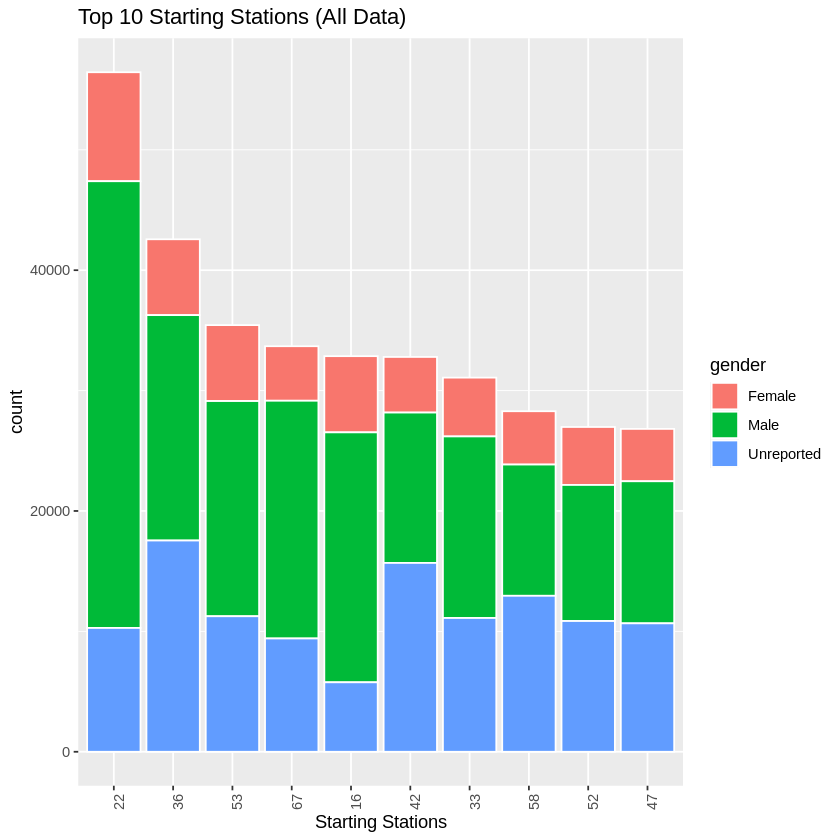

In [ ]:
                     # ALL Data
                      reorder_size <- function(x) {
                        factor(x, levels = names(sort(table(x), decreasing = TRUE)))
                      }
                      ggplot(ugenpopstart, aes(x = reorder_size(strt_statn))) +
                        geom_bar(aes(fill=gender), color="white") +
                        xlab("Starting Stations") +
                        theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                        ggtitle("Top 10 Starting Stations (All Data)")

strt_statn,Count
<fct>,<int>
22,46156
16,27089
36,25021
67,24274
53,24181
33,19964
43,19427
48,19020
40,18892


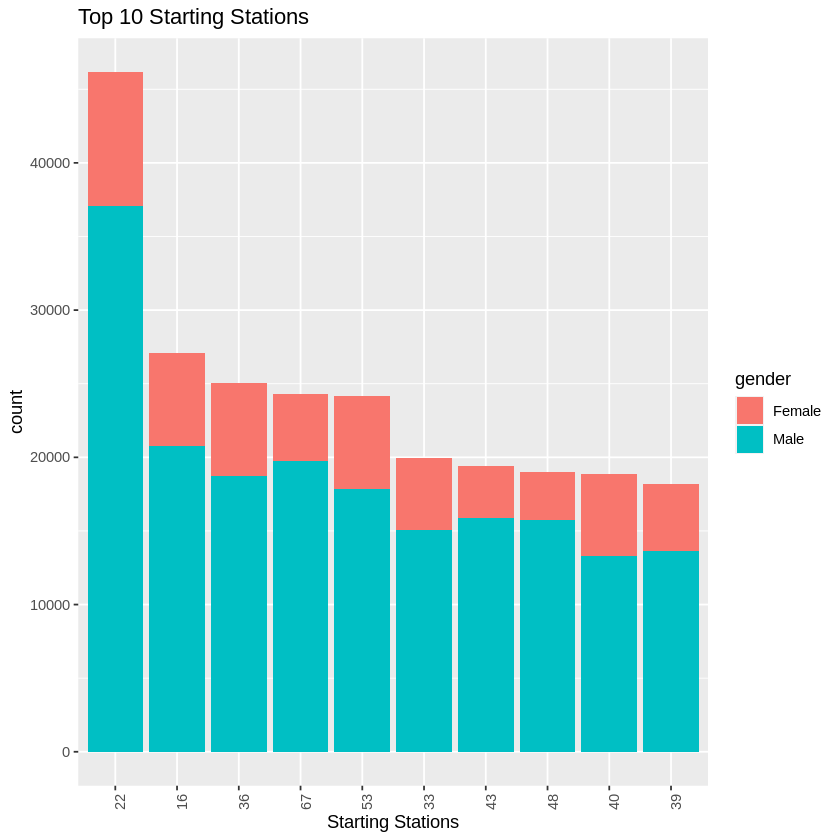

In [ ]:
       # Excluding Unreported Gender
                # Top Starting Locations
                poptrips %>%
                  filter(gender!="Unreported") %>%
                  group_by(strt_statn) %>%
                  summarize(Count=n()) %>%
                  arrange(desc(Count))

                # Top 10 Start by Gender
                newtopstations <- c("22","16","36","67","53","33","43","48","40","39")
                genpopstart <- poptrips %>%
                  filter(gender!="Unreported") %>%
                  filter(strt_statn %in% newtopstations)

                # top 10 Plots
                reorder_size <- function(x) {
                  factor(x, levels = names(sort(table(x), decreasing = TRUE)))
                }
                ggplot(genpopstart, aes(x = reorder_size(strt_statn))) +
                  geom_bar(aes(fill=gender)) +
                  xlab("Starting Stations") +
                  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                  ggtitle("Top 10 Starting Stations")

end_statn,Count
<fct>,<int>
22,56280
36,43387
42,34916
67,34580
53,33369
33,32246
16,29665
43,27738
52,27222


gender,n,precent
<fct>,<int>,<dbl>
Male,834688,52.86272
Unreported,472592,29.93034
Female,271693,17.20694


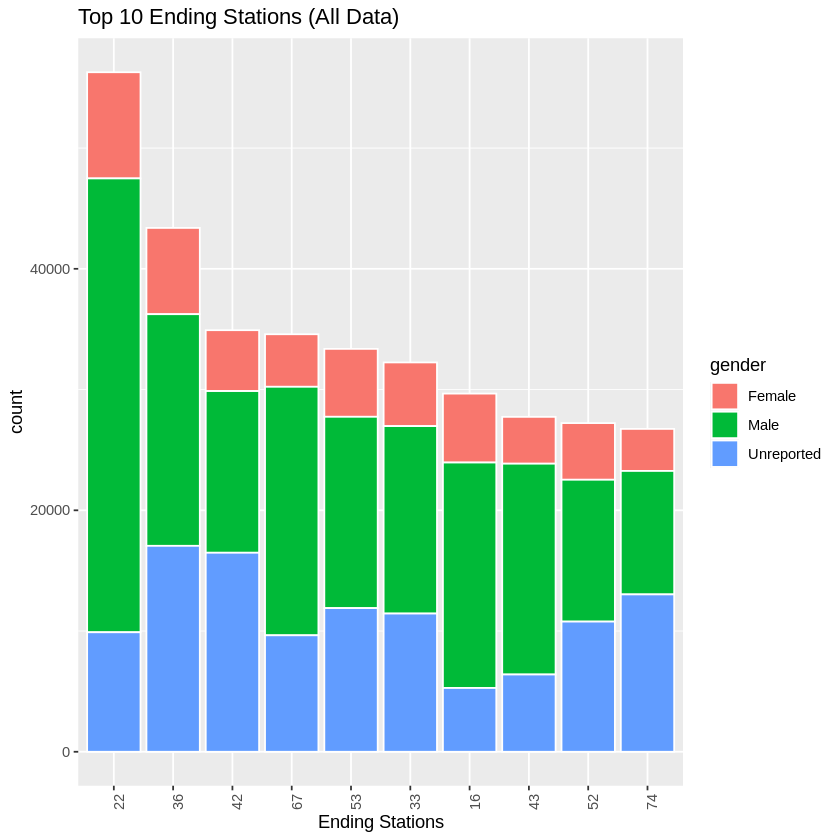

In [ ]:
    #--- Ending Stations ---#
        ### By Gender ###

        # ALL DATA
                  # Top Ending Locations
                  poptrips %>%
                    group_by(end_statn) %>%
                    summarize(Count=n()) %>%
                    arrange(desc(Count))

                  # Percentage of Gender Reported
                  poptrips %>%
                    group_by(gender) %>%
                    summarise (n = n()) %>%
                    mutate(precent = (n / sum(n))*100) %>%
                    arrange(desc(precent))

                  # Top 10 End by Gender (All Data)
                  topstations <- c("22","36","42","67","53","33","16","43","52","74")
                  ugenpopend <- poptrips %>%
                    filter(end_statn %in% topstations)


                  # ALL Data
                  reorder_size <- function(x) {
                    factor(x, levels = names(sort(table(x), decreasing = TRUE)))
                  }
                  ggplot(ugenpopend, aes(x = reorder_size(end_statn))) +
                    geom_bar(aes(fill=gender), color="white") +
                    xlab("Ending Stations") +
                    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                    ggtitle("Top 10 Ending Stations (All Data)")

end_statn,Count
<fct>,<int>
22,46382
36,26331
67,24934
16,24381
53,21469
43,21338
33,20798
48,20772
21,18452


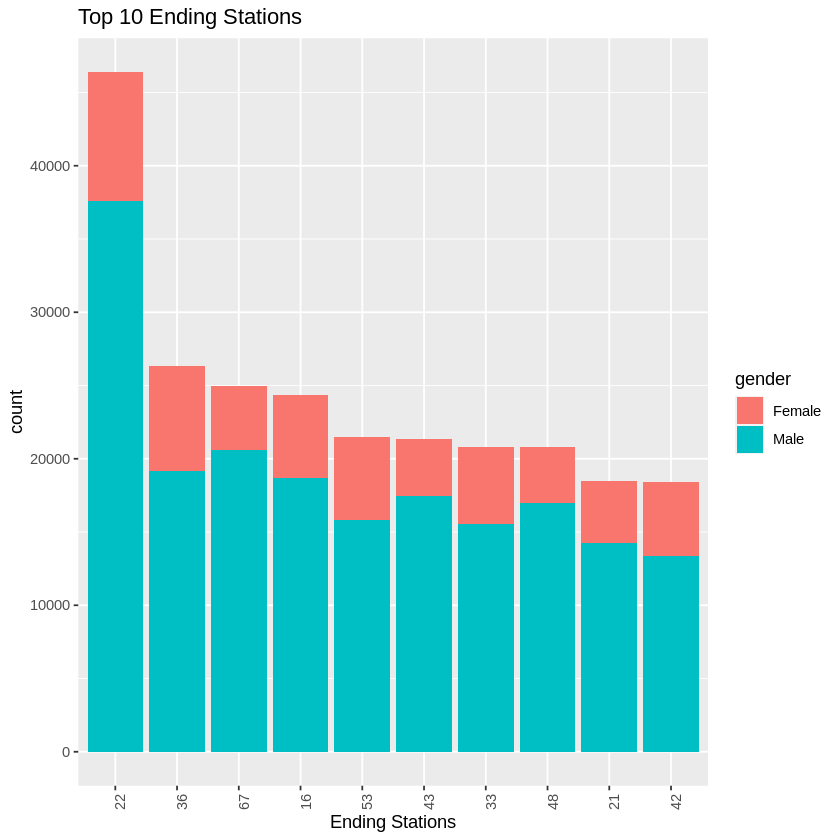

In [ ]:
        # Excluding Unreported Gender
                  # Top Ending Locations
                  poptrips %>%
                    filter(gender!="Unreported") %>%
                    group_by(end_statn) %>%
                    summarize(Count=n()) %>%
                    arrange(desc(Count))

                  # Top 10 end by Gender
                  newtopstations <- c("22","36","67","16","53","43","33","48","21","42")
                  genpopend <- poptrips %>%
                    filter(gender!="Unreported") %>%
                    filter(end_statn %in% newtopstations)

                  # top 10 Plots
                  reorder_size <- function(x) {
                    factor(x, levels = names(sort(table(x), decreasing = TRUE)))
                  }
                  ggplot(genpopend, aes(x = reorder_size(end_statn))) +
                    geom_bar(aes(fill=gender)) +
                    xlab("Ending Stations") +
                    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
                    ggtitle("Top 10 Ending Stations")

        # Station 22 is South Station - 700 Atlantic Ave. (This is the Main Transportation hub in Downtown Boston)
        # Station 36 is Boston Public Library - 700 Boylston St.  (Boston Public Library)
        # Station 67 is MIT at Mass Ave / Amherst St (MIT)
        # Station 53 is Beacon St / Mass Ave (Boston University)
        # Station 16 is Back Bay / South End Station (ANother major transportation hub)

We looked at the most travelled station and saw that the most traveled incoming and outgoing trips were the same locations which indicated that many of these trips were round trips. The leads us to further believe our hypothesis that most of these trips are to and from work.
<br>
<br>
Next we did a little research on some of the most traveled station to get an idea of where and why people were going to these locations. We found the following information:
* South Station/700 Atlantic Ave - Major transportation hub in downtown Boston
  * these are most likely individuals taking the subway into the major transportation hubs and then taking bikes from there to their place of employment. Similar behavior is observed in NYC.
* Boston Public Library/700 Boylston - This is the location of the Boston Public Library. Used by students but also a turist location.
* MIT at Mass/Amherst - Nearest station to Mass Institute of Technology (MIT)
  * Potentially students, professors and university staff
* Beacon St/Mass Ave - Nearest station to Boston University
* Back Bay/South End - Major transortation hub in downtown Boston
* Boylston St at Arlington - Boston Garden and the Arington Street Church (tourist sites)
* Charles Circle - Major transportation hub in downtown Boston

Warning message:
“Factor `station` contains implicit NA, consider using `forcats::fct_explicit_na`”


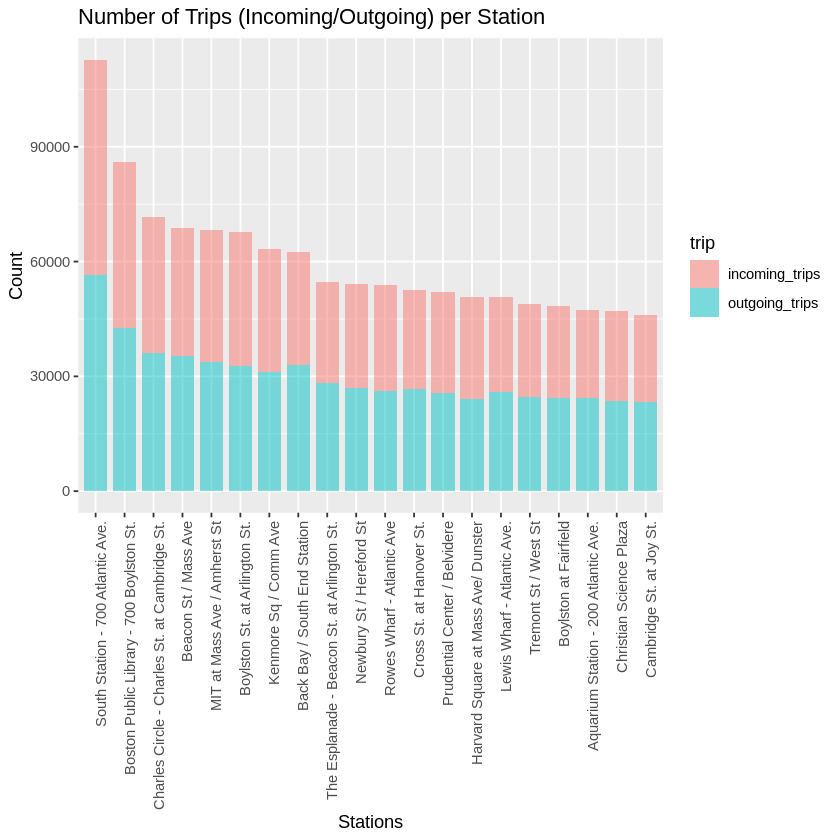

In [ ]:
#-------------------Incoming/outgoing trips per station--------------------#


# Creating Data for plotting
          #aggregate by station and sort by count
                hubway_trips %>% group_by(strt_statn) %>% summarise(outgoing_trips=n()) %>%
                  as.data.frame() %>% arrange(., desc(outgoing_trips)) %>% rename(id = strt_statn) -> trips.o

                hubway_trips %>% group_by(end_statn) %>% summarise(incoming_trips=n()) %>%
                  as.data.frame() %>% arrange(., desc(incoming_trips)) %>% rename(id = end_statn) -> trips.i

          # merge by station and add station info from hubway.stations
          full_join(trips.o, trips.i, by = "id") -> trips.station
          left_join(trips.station, hubway_stations, by = "id") %>% select(station, outgoing_trips, incoming_trips) %>%
            group_by(station) %>% summarise(outgoing_trips=sum(outgoing_trips), incoming_trips=sum(incoming_trips))  %>%
            arrange(., desc(outgoing_trips), desc(incoming_trips)) -> trips.station

          # top 20
          trips.station %>% slice(1:20) -> trips.station

          # gather for plotting
          trips.station %>% gather ("trip","count", 2:3) %>%
            arrange(., desc(count))-> trips.station

# Plotting Data
          ggplot(trips.station, aes(x = reorder(station, -count), y=count, fill=trip)) +
            geom_bar(stat="identity",color=I("black"), size=0,alpha = 0.5,width=0.8) +
            xlab("Stations") + ylab("Count") +
            theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
            ggtitle("Number of Trips (Incoming/Outgoing) per Station")


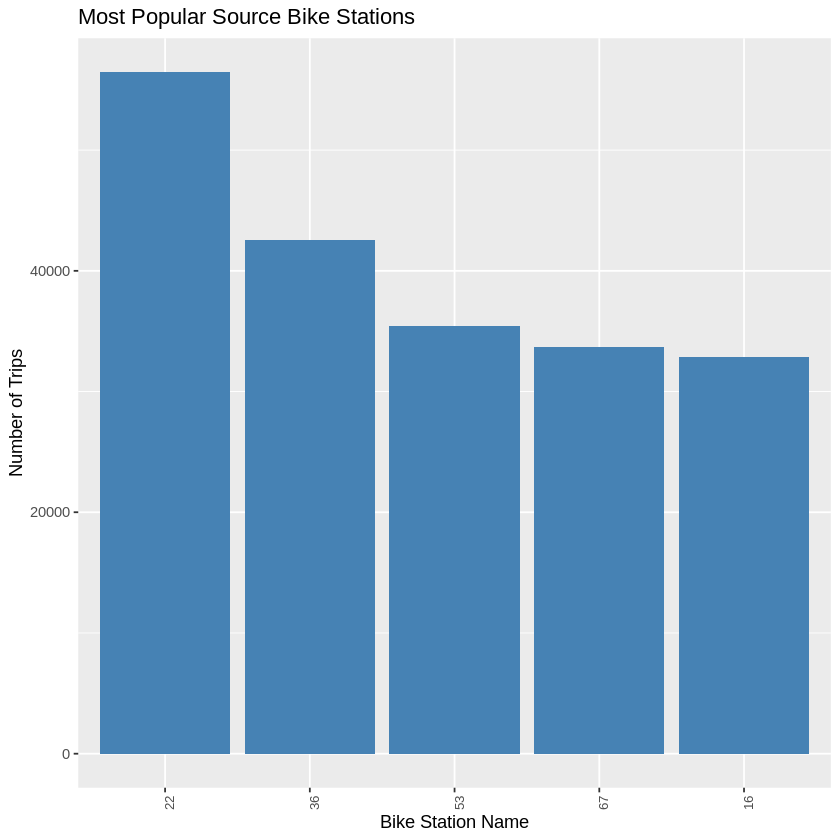

In [ ]:
#------- Most popular source stations-----------------#

#group trips by start station name and count number of trips for each station

          hubway_trips$strt_statn_name <- as.character(trips$strt_statn)
          hubway_trips$end_statn_name  <- as.character(trips$end_statn)

          tripsby_strt_statn <- hubway_trips %>%
            group_by(strt_statn_name) %>%
            summarise(number_trips = n()) %>%
            select(strt_statn_name, number_trips) %>%
            arrange(desc(number_trips)) %>%
            ungroup()
          tripsby_strt_statn$strt_statn_name <- factor(tripsby_strt_statn$strt_statn_name,
                                                       levels = tripsby_strt_statn$strt_statn_name, ordered = TRUE)
#Plot
        ggplot(data = tripsby_strt_statn[1:5, ],
               aes(x = strt_statn_name, y = number_trips)) +
          geom_bar(fill = 'steelblue', stat = 'identity') +
          ggtitle("Most Popular Source Bike Stations")+
          ylab("Number of Trips") +
          xlab("Bike Station Name") +
          theme(axis.text.x = element_text(size = 8))+theme(axis.text.x = element_text(angle = 90, hjust = 1))

## Summary
Based on what we the data and the visualizations, we are seeing that from 8AM - 5PM, there is a lot of transportation to and from three major transportation hubs in downtown Boston. We believe these are people coming into downtown Boston for work and taking bicycles to their actual work location. When the work day is over, they are picking up bikes neear theor work of emplyment and returning back to the major hubs. This is why we believe we are seeing so many trips to and from the hubs. This matches with the data showing that the majority of trips being during the work week.
<br>
<br>
We are also seeing toursit travel to some tourist locations, but these toursists may also be traveling to the major transportation hubs to get around the city.
<br>
<br>
Lastly, we created a fullsize poster to display our findings to our target audience. We looked into [Blue Bikes's Branding Guidlines](https://motivateco.app.box.com/s/cw4tluatehnpfff4wzmch7v2f4ewa0uz) to see what fonts and colors the company used in all their materials. We chose those same fonts and color scheme for our visualizations. The full size version of the poster can be downloaded for better viewing by clicking on the link
[Full Size Poster](https://github.com/frnunez/frnunez.github.io/raw/master/images/visualization/finalposter.jpg)

## Poster
![alt text](https://github.com/frnunez/frnunez.github.io/raw/master/images/visualization/finalpostersmall.jpg)